In [1]:
import os
import operator
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [3]:
# Define globals
### network name <=> data file mapping
_FILEMAP_={'vgg16a' : 'sp_vgg16a_iter_',
           'vgg16b' : 'sp_vgg16b_iter_',
           'vgg16c' : 'sp_vgg16c_iter_',
           'resnet14b'    : 'sp_resnet14b_iter_',
#           'resnet14b_w4' : 'sp_resnet14b_w4_iter_',
           'resnet29b'    : 'sp_resnet29b_iter_',
#           'resnet29b_w2' : 'sp_resnet29b_w2_iter_',
           'resnet29b_w4' : 'sp_resnet29b_w4_iter_',
           'resnet50b'    : 'sp_resnet50b_iter_',
           'plainresnet10b'    : 'sp_plainresnet10b_iter_',
#           'plainresnet10b_w4' : 'sp_plainresnet10b_w4_iter_',
#           'plainresnet12b'    : 'sp_plainresnet12b_iter_',
#           'plainresnet18b'    : 'sp_plainresnet18b_iter_',
#           'plainresnet18b_w4' : 'sp_plainresnet18b_w4_iter_',
#           'plainresnet20b'    : 'sp_plainresnet20b_iter_',
#           'plainresnet20b_w4' : 'sp_plainresnet20b_w4_iter_'
          }
_DATAMAP_={}
_FILEDIR_='testB'
_LABELS_=['eminus','gamma','muminus','piminus','proton']

In [4]:
class Analysis:
    """
        Class encapsulation of analysis routines
    """
    total_file_list = os.listdir(_FILEDIR_)
    
    def __init__(self, netname):
        """
            A single instance corresponds to a single network
        """
        self.netname = netname
        self._iter_files=None
        self._iter_map ={}

    @property
    def iter_files(self):
        """
            Gets a list of all files corresponding to this network
        """
        if self._iter_files is not None: return self._iter_files
        return [i for i in self.total_file_list if self.netname in i]
        
    @property
    def iter_map(self):
        """
            Returns a  map of iteration->iteration file
        """
        if len(self._iter_map)>0: return self._iter_map
        for i in self.iter_files:
            self._iter_map[int(i.strip('.csv').split("_")[-1])]= os.path.join(_FILEDIR_,i)
        return self._iter_map
    
    @property
    def iter_sorted(self):
        """
            Returns a sorted list of iterations
        """
        return [key for key in sorted(self.iter_map.iterkeys())]
    
    def df(self, iteration):
        """
            Get the dataframe for a specific iteration
        """
        return pd.read_csv(self.iter_map[iteration], error_bad_lines=False)
    
    def __repr__(self):
        return """
               Purity Analysis on Network: {}
               Iterations: {}
               """.format(self.netname, self.iter_sorted)

    def analyze(self):
        """
            Get the total recall efficiency for all associated weight files.
            This can be done more efficiently.
        """
        results={
            'name': self.netname,
            'iter': None,
            'max_efficiency': None
        }
        
        # maps iteration number to efficiency
        iter_eff_map={}   
        for iteration in self.iter_sorted:
            df = self.df(iteration)
            correct_values = df.query('label==prediction')
            incorrect_values = df.query('label!=prediction')
            if len(correct_values) == 0: continue # disregard networks with no efficiency
            # seems tedious, but also technically correct.
            # This could be done in strict pandas, but as this
            # is the critical step, I'm doing it as transparent
            # as possible. Also, this is bad coding practice
            iter_eff_map[iteration] = float(len(correct_values))/(len(correct_values)+len(incorrect_values))
        results['iter'] = max(iter_eff_map.iteritems(), key=operator.itemgetter(1))[0]
        results['max_efficiency'] = iter_eff_map[results['iter']]
        return results

In [5]:
analyses = [Analysis(i) for i in _FILEMAP_ ]
#print analyses

In [6]:
analysis_results = [i.analyze() for i in analyses if len(i.iter_sorted)>0]
names = [i.netname for i in analyses]

In [7]:
print analysis_results
#save to json for later
import json
with open('weights.json', 'w') as fp:
    json.dump({'results':analysis_results}, fp)

[{'max_efficiency': 0.8687333333333334, 'name': 'vgg16a', 'iter': 141000}, {'max_efficiency': 0.8791333333333333, 'name': 'vgg16c', 'iter': 222000}, {'max_efficiency': 0.882, 'name': 'vgg16b', 'iter': 114000}, {'max_efficiency': 0.8609333333333333, 'name': 'resnet14b', 'iter': 289000}, {'max_efficiency': 0.4704263075664013, 'name': 'plainresnet10b', 'iter': 108250}, {'max_efficiency': 0.8807, 'name': 'resnet29b', 'iter': 430500}, {'max_efficiency': 0.879, 'name': 'resnet29b_w4', 'iter': 348000}, {'max_efficiency': 0.8831333333333333, 'name': 'resnet50b', 'iter': 428250}]


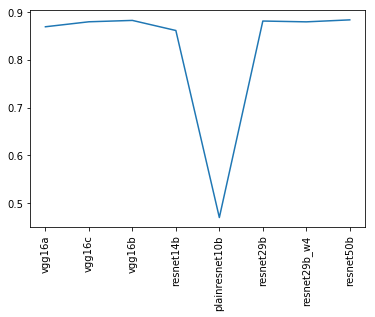

In [8]:
plt.figure()
x_labels = [i['name'] for i in analysis_results]
x = range(len(analysis_results))
y = [i['max_efficiency'] for i in analysis_results]
plt.plot(x,y )
plt.xticks(x,x_labels, rotation='vertical')
plt.show()

In [9]:
print _FILEMAP_


{'vgg16a': 'sp_vgg16a_iter_', 'vgg16c': 'sp_vgg16c_iter_', 'vgg16b': 'sp_vgg16b_iter_', 'resnet14b': 'sp_resnet14b_iter_', 'plainresnet10b': 'sp_plainresnet10b_iter_', 'resnet29b': 'sp_resnet29b_iter_', 'resnet29b_w4': 'sp_resnet29b_w4_iter_', 'resnet50b': 'sp_resnet50b_iter_'}
